In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df_alt = pd.read_csv(r"C:\Users\mvana\Documents\MSc\Temp_O3_H2O\Data\saber_agg.csv")
df_alt['year_month'] = pd.to_datetime(df_alt['year_month']).dt.to_period('M')

df = df_alt.groupby(['year_month', 'year', 'month'])[['ktemp']].mean().reset_index()

df = df.sort_values('year_month').reset_index(drop=True)

# Convert 'year_month' from period to datetime for plotting
df['date'] = df['year_month'].dt.to_timestamp()

# Add time index for trend fitting
df['time_index'] = np.arange(len(df))
X = df[['time_index']]
y = df['ktemp']

In [3]:
# Deseasonalize the temperature
# Group by month to get climatology
monthly_clim = df.groupby(df['date'].dt.month)['ktemp'].transform('mean')
df['deseasonalized'] = df['ktemp'] - monthly_clim

# Time and driver terms
df['time_index'] = np.arange(len(df))  # Time in months

# Prepare the regression matrix
X = df[['time_index', 'year', 'month']]
X = sm.add_constant(X)
y = df['deseasonalized']

# Fit the MLR model
model = sm.OLS(y, X).fit()
df['y_MLR'] = model.predict(X)
df['residuals'] = df['deseasonalized'] - df['y_MLR']

# Forecast future values
future_months = 60
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(), periods=future_months, freq='MS')

# Extract future year and month from future dates
future_year = future_dates.year
future_month = future_dates.month
future_t = np.arange(df['time_index'].iloc[-1] + 1, df['time_index'].iloc[-1] + 1 + future_months)

future_data = pd.DataFrame({
    'const': 1.0,
    'time_index': future_t,
    'year': future_year,
    'month': future_month
})

# Predict future deseasonalized temperatures using the fitted model
future_y_MLR = model.predict(future_data)

# Combine results
df_future = pd.DataFrame({
    'date': future_dates,
    'y_MLR': future_y_MLR
})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year_month      276 non-null    period[M]     
 1   year            276 non-null    int64         
 2   month           276 non-null    int64         
 3   ktemp           276 non-null    float64       
 4   date            276 non-null    datetime64[ns]
 5   time_index      276 non-null    int32         
 6   deseasonalized  276 non-null    float64       
 7   y_MLR           276 non-null    float64       
 8   residuals       276 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int32(1), int64(2), period[M](1)
memory usage: 18.5 KB


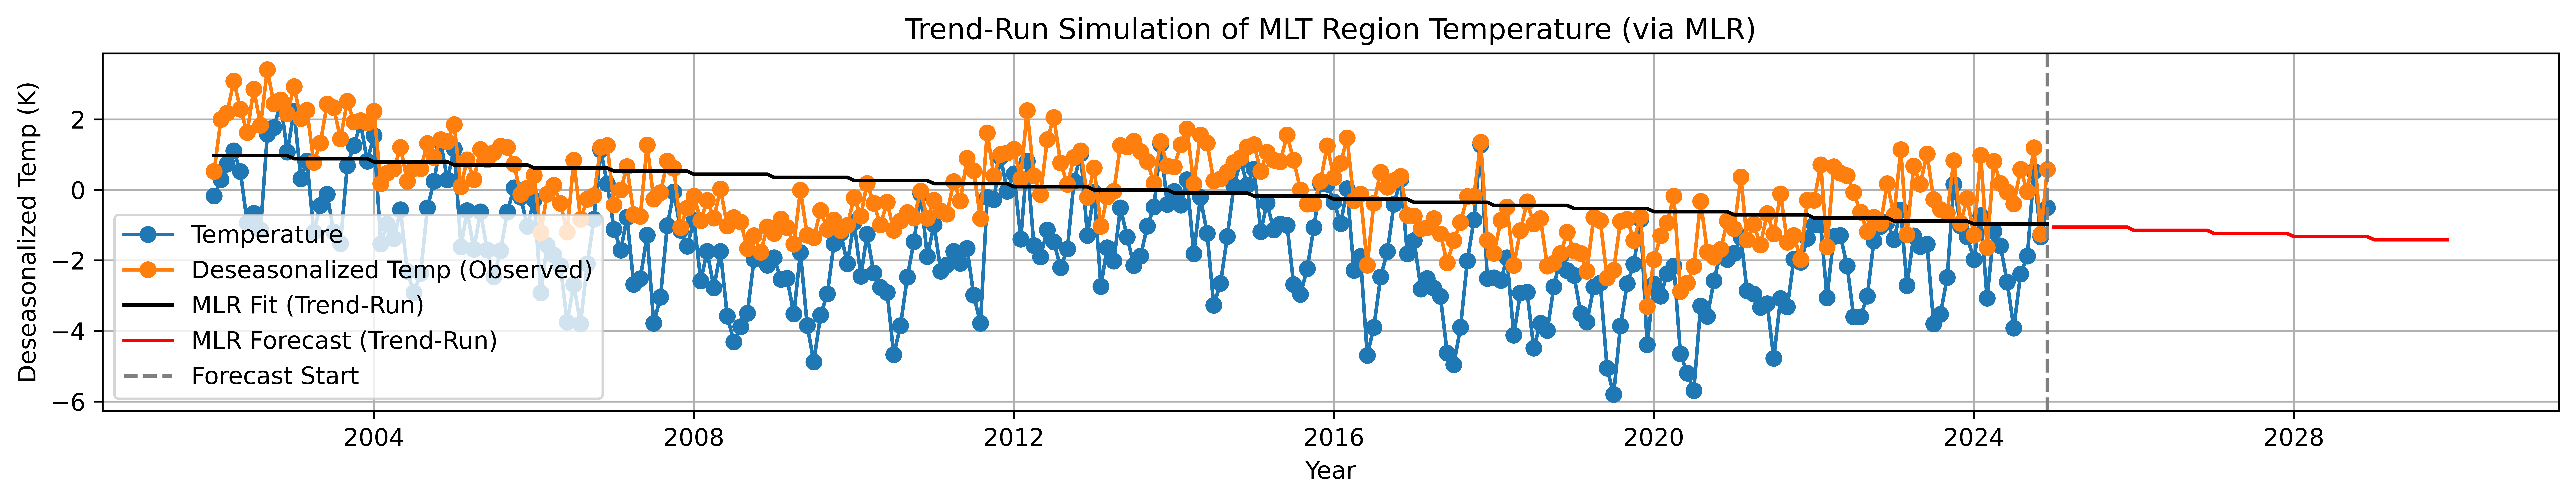

In [11]:
# Plot
plt.figure(figsize=(15, 3), dpi=1000)
plt.plot(df['date'], df['ktemp']-213, label='Temperature', marker = 'o')
plt.plot(df['date'], df['deseasonalized'], label='Deseasonalized Temp (Observed)', marker = 'o')
plt.plot(df['date'], df['y_MLR'], label='MLR Fit (Trend-Run)', color='black')
plt.plot(df_future['date'], df_future['y_MLR'], label='MLR Forecast (Trend-Run)', color='red')
plt.axvline(df['date'].iloc[-1], color='gray', linestyle='--', label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Deseasonalized Temp (K)')
plt.title('Trend-Run Simulation of MLT Region Temperature (via MLR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         deseasonalized   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     40.64
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           3.55e-16
Time:                        19:45:07   Log-Likelihood:                -411.30
No. Observations:                 276   AIC:                             828.6
Df Residuals:                     273   BIC:                             839.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.568e-07   7.59e-07      1.129      0.2